<div align='left' style="width:29%;overflow:hidden;">
<a href='http://inria.fr'>
<img src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/inr_logo_rouge.png' alt='Inria logo' title='Inria logo'/>
</a>
</div>

# Exploring CORD-19 references

This notebooks explores how much information we can obtain from the citation references of the papers in the COVID-19 Open Research Dataset Challenge.

Here we are trying to:

- Load the dataset.
    - How many papers can we parse?
- How to extract the references?
- How many references are also in the CORD-19 dataset?
- How many are out?

In [ ]:
# default_exp references

Making sure that all requirements are installed.

In [ ]:
!pip install -q -r requirements.txt

In [18]:
# export
# removing ugly pandas warning in macOS
import warnings
warnings.filterwarnings("ignore", ".*lzma.*")

In [1]:
#export
import pandas as pd
import numpy as np
import networkx as nx

from fastprogress.fastprogress import progress_bar

from pathlib import Path

import json
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('notebook')

## Loading the CORD-19 dataset

In [2]:
cord19_dataset_folder = "./datasets/CORD-19-research-challenge"

In [3]:
if Path(cord19_dataset_folder).exists():
    print('Good to go')
else:
    print(f'{data_root} does not exist! Download it using 00_download.ipynb.')

Good to go


Loading `metadata.csv` file as a pandas `DataFrame`.

In [4]:
metadata_df = pd.read_csv(f"{cord19_dataset_folder}/metadata.csv", index_col="cord_uid")

/home/rpalma/repos/risotto/risotto-notebooks/venv-risotto-notebooks/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


How metadata looks like?

In [5]:
file_in_metadata_count = len(metadata_df)

In [6]:
f'Total records loaded: {file_in_metadata_count}'

'Total records loaded: 128492'

In [7]:
metadata_df.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [8]:
(metadata_df["pdf_json_files"].isna() & metadata_df["pmc_json_files"].isna()).sum()

70035

Each paper is represented by a unique id called `cord_uid`.

Meaning of columns:

- `sha`: PDF file hash
- `source_x`: source repository, e.g. Biorxiv, Elsevier, etc.
- `title`: paper title
- `doi`, `pmcid`, `pubmed_id`, `Microsoft Academic Paper ID`, `WHO #Covidence`: other document ids
- `license`: usage license
- `abstract`:plain text abstract
- `publish_time`: publish date
- `journal`: academic journal of publication, if applicable
- `authors`: authors in plain text
- `has_pdf_parse`: if PDF parsing is available
- `has_pmc_xml_parse`: if PubMed XML is available
- `full_text_file`: pointer to the source file in the dataset
- `url`: URL to paper online source

The following cells will explore the folders and files structure of the dataset.

In [9]:
def _sample_json_file(path):
    for _, _, file_names in os.walk(path):
        sample_file_name = random.choice(file_names)
        file_path = os.path.join(path, sample_file_name)
        with open(file_path) as file:
            contents = json.load(file)
        return list(contents.keys())

In [10]:
def walk_dataset():
    cum_sum = 0
    for root, folders, files in os.walk(cord19_dataset_folder):
        num_folders = len(folders)
        num_files = len(files)
        if "json" in root and num_folders == 0 and num_files > 0:
            cum_sum += num_files
            print(f"{root}: {num_files} files")
    return cum_sum

In [11]:
source_file_count = walk_dataset()

./datasets/CORD-19-research-challenge/document_parses/pdf_json: 59561 files
./datasets/CORD-19-research-challenge/document_parses/pmc_json: 43753 files


In [12]:
print(f'Files in metadata: {file_in_metadata_count}, source files: {source_file_count}')

Files in metadata: 128492, source files: 103314


In [13]:
print(f'We have {source_file_count-file_in_metadata_count} files without metadata.')

We have -25178 files without metadata.


According to the information found in the Kaggle community site, there are at least two recommended procedures to load the dataset.

```python
# First method
for row in metadata_file:
    pmc_id = row["pmc_id"]
    if exists pmc_id file in pmc_jsons subfolders:
        return pmc_id file
    # If `pmc_id` is null or there is no file
    sha = row["sha"]
    if exists sha file in pdf_jsons subfolders:
        return sha file

# Second method
for pdf file in pdf files:
    if pdf file sha not in metadata_file shas:
        continue
    else:
        row = metadata_file row with matching pdf file sha
        pmc_id = row["pmc_id"]
        if exists pmc_id file in pmc_jsons subfolders:
            return pmc_id file
        return pdf file
```

In [14]:
#exports
def get_id_paths_dicts(cls, cord19_dataset_folder):
    """
    DEPRECATED.
    This function builds the dictionaries whose keys are identifiers
    of some kind of papers (PDF or PMC) and whose values are the paths to
    associated files.
    """
    all_files = {}
    for root, folders, files in os.walk(cord19_dataset_folder):
        num_folders = len(folders)
        num_files = len(files)
        if cls in root and num_folders == 0 and num_files > 0:
            for file_name in files:
                _id = file_name.split(".")[0]
                all_files[_id] = os.path.join(root, file_name)
    return all_files

In [15]:
pdf_dict = get_id_paths_dicts("pdf", cord19_dataset_folder)
pmc_dict = get_id_paths_dicts("pmc", cord19_dataset_folder)

In [16]:
print(f'Number of PDF files with parse JSON {len(pdf_dict)}')
print(f'Number of PMC files with parse JSON {len(pmc_dict)}')

Number of PDF files with parse JSON 59561
Number of PMC files with parse JSON 43753


## Loading PDF and PMC papers

In [17]:
# exports
class BasePaper:
    def __init__(self, metadata_row, file_path):
        self._metadata_row = metadata_row
        self._file_path = file_path
        self._file_contents = self._load_json_contents(file_path)
        
        self._referenced_by = []
        self._references = []
    
    def __getstate__(self):
        """
        Avoid RecursionErrors by not pickling references.
        """
        state = self.__dict__.copy()
        del state["_referenced_by"]
        del state["_references"]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)
        self._referenced_by = []
        self._references = []
        
    @staticmethod
    def _load_json_contents(path):
        with open(path) as file:
            contents = json.load(file)
        return contents

    @property
    def title(self):
        return self._metadata_row["title"]
        
    @property
    def authors(self):
        return self._metadata_row["authors"]
        
    @property
    def publish_time(self):
        return self._metadata_row["publish_time"]
        
    @property
    def abstract(self):
        return self._metadata_row["abstract"]
        
    @property
    def bib_entries(self):
        return self._file_contents["bib_entries"]
    
    @property
    def doi(self):
        return self._metadata_row["doi"]

    @property
    def url(self):
        return self._metadata_row["url"]
    
    def register_reference(self, reference):
        self._references.append(reference)
        reference.register_referenced(self)
    
    def register_referenced(self, referenced):
        self._referenced_by.append(referenced)

In [18]:
#exports
class PDFPaper(BasePaper):
    pass

In [19]:
#exports
class PMCPaper(BasePaper):
    pass

In [20]:
#exports
def load_papers_from_metadata_file(cord19_dataset_folder):
    'Loads papers by reading the `metadata.csv` file present in the dataset.'
    metadata_df = pd.read_csv(f"{cord19_dataset_folder}/metadata.csv",
                              index_col="cord_uid")
    """
    pdf_dict = get_id_paths_dicts("pdf", cord19_dataset_folder)
    pmc_dict = get_id_paths_dicts("pmc", cord19_dataset_folder)
    """

    papers = []
    # not_found = []
    for idx, row in progress_bar(metadata_df.iterrows(),
                                 total=len(metadata_df)):
        
        paper = None
        pmc_rel_path = row["pmc_json_files"]
        pdf_rel_path = row["pdf_json_files"]
        
        if pd.notna(pmc_rel_path):
            path = os.path.join(cord19_dataset_folder, pmc_rel_path)
            paper = PMCPaper(row, path)
        
        if pd.notna(pdf_rel_path):
            path_splitted = pdf_rel_path.split("; ")[0]
            path = os.path.join(cord19_dataset_folder, path_splitted)
            paper = PDFPaper(row, path)
        
        if paper is not None:
            papers.append(paper)

    return papers

In [21]:
papers = load_papers_from_metadata_file(cord19_dataset_folder)

/home/rpalma/repos/risotto/risotto-notebooks/venv-risotto-notebooks/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [22]:
print(f'{len(papers)} papers found')

58457 papers found


In [23]:
mask_1 = metadata_df["pmc_json_files"].notna()
mask_2 = metadata_df["pdf_json_files"].notna()
print(
    f'There are {(mask_1 | mask_2).sum()} files with either parsed PDF or PMC XML.'
)

There are 58457 files with either parsed PDF or PMC XML.


## Peeking at the paper info we just loaded

In [24]:
# exports
def paper_as_markdown(paper):
    from IPython.display import display, Markdown
    res = f"""
- **Title:** {paper.title}
- **Authors:** {paper.authors}
- **Publish date/time:** {paper.publish_time}
- **Linked references:** {len(paper._references)}
- **Linked referenced by:** {len(paper._referenced_by)}
- **Abstract:** {paper.abstract}"""
    display(Markdown(res))

In [25]:
paper = random.sample(papers, 1)[0]
paper_as_markdown(paper)


- **Title:** Identification and molecular cloning of a novel porcine parvovirus
- **Authors:** Cheung, Andrew K.; Wu, Guang; Wang, David; Bayles, Darrell O.; Lager, Kelly M.; Vincent, Amy L.
- **Publish date/time:** 2010-03-26
- **Linked references:** 0
- **Linked referenced by:** 0
- **Abstract:** A novel porcine parvovirus, PPV4, was identified in the lung lavage of a diseased pig coinfected with porcine circovirus type 2. This virus exhibits limited similarity to its closest relative, bovine parvovirus 2, but resembles viruses of the genus Bocavirus (bovine parvovirus, canine minute virus and human bocavirus) that encode an additional ORF3. The ORF3 of PPV4 is predicted to encode a protein of 204 amino acid residues, which is similar in size to the ORF3-encoded proteins of the bocaviruses. Whereas the ORF3-encoded proteins of bocaviruses share significant similarity with each other, the PPV4 ORF3 encoded protein does not exhibit homology with any protein in the GenBank non-redundant database.

## Matching references to titles

We now make the match between the titles (in plain text) of the references of each paper and their titles.

A dictionary to map titles to papers.

In [26]:
# exports
def process_references(papers):
    paper_titles = {}
    for paper in progress_bar(papers):
        title = paper.title
        if isinstance(title, str):  # coping with NaNs in titles
            paper_titles[title.lower()] = paper

    num_processed_refs = 0
    num_succesfully_processed_refs = 0
    for paper in progress_bar(papers):
        for _, ref in paper.bib_entries.items():
            ref_title = ref["title"].lower()
            if ref_title in paper_titles:
                paper.register_reference(paper_titles[ref_title])
                num_succesfully_processed_refs += 1
        num_processed_refs += len(paper.bib_entries)
    return num_processed_refs, num_succesfully_processed_refs

In [29]:
num_processed_refs, num_succesfully_processed_refs = process_references(papers)

In [30]:
print(f'Total references: {num_processed_refs}.')
print(f'References present in the dataset {num_succesfully_processed_refs} ({num_succesfully_processed_refs/num_processed_refs*100}%).')

Total references: 2725726.
References present in the dataset 194504 (7.135860317581444%).


One strategy to mitigate that less than 7% of references are also in the dataset is to create special nodes for the papers outside the set, in this way the structure of the graph is better preserved.

On the other hand, other questions must be answered:

- How many papers are referenced at least once in the data set?
- What are the most referenced papers in the dataset? Long tail?
- What are the most referenced papers outside the dataset? Long tail?

In [31]:
num_references = 0
num_referenced_by = 0
for paper in papers:
    if len(paper._references) > 0:
        num_references += 1
    if len(paper._referenced_by) > 0:
        num_referenced_by += 1

Questions:

- How many papers have at least one referece correctly linked?
- How many papers have been references at least once?

In [ ]:
print(f'Total papers: {len(papersld)}.')
print(f'Number of references {num_references} ({num_references/len(papers)*100}%).')
print(f'Number of referenced-by {num_referenced_by} ({num_referenced_by/len(papers)*100}%).')

Total papers: 44648.
Number of references 29332 (65.69611180791973%).
Number of referenced-by 20245 (45.34357641999642%).


What are the most reference papers?

In [ ]:
papers_sorted = sorted(papers, key=lambda p: len(p._referenced_by), reverse=True)

Most cited paper:

In [ ]:
paper_as_markdown(papers_sorted[0])


- **Title:** Coronavirus as a possible cause of severe acute respiratory syndrome
- **Authors:** Peiris, JSM; Lai, ST; Poon, LLM; Guan, Y; Yam, LYC; Lim, W; Nicholls, J; Yee, WKS; Yan, WW; Cheung, MT; Cheng, VCC; Chan, KH; Tsang, DNC; Yung, RWH; Ng, TK; Yuen, KY
- **Publish date/time:** 2003-04-19
- **Linked references:** 4
- **Linked referenced by:** 773
- **Abstract:** Summary Background An outbreak of severe acute respiratory syndrome (SARS) has been reported in Hong Kong. We investigated the viral cause and clinical presentation among 50 patients. Methods We analysed case notes and microbiological findings for 50 patients with SARS, representing more than five separate epidemiologically linked transmission clusters. We defined the clinical presentation and risk factors associated with severe disease and investigated the causal agents by chest radiography and laboratory testing of nasopharyngeal aspirates and sera samples. We compared the laboratory findings with those submitted for microbiological investigation of other diseases from patients whose identity was masked. Findings Patients' age ranged from 23 to 74 years. Fever, chills, myalgia, and cough were the most frequent complaints. When compared with chest radiographic changes, respiratory symptoms and auscultatory findings were disproportionally mild. Patients who were household contacts of other infected people and had older age, lymphopenia, and liver dysfunction were associated with severe disease. A virus belonging to the family Coronaviridae was isolated from two patients. By use of serological and reverse-transcriptase PCR specific for this virus, 45 of 50 patients with SARS, but no controls, had evidence of infection with this virus. Interpretation A coronavirus was isolated from patients with SARS that might be the primary agent associated with this disease. Serological and molecular tests specific for the virus permitted a definitive laboratory diagnosis to be made and allowed further investigation to define whether other cofactors play a part in disease progression.

... and its refereces.

In [ ]:
for paper in papers_sorted[0]._references:
     paper_as_markdown(paper)


- **Title:** Severe Acute Respiratory Syndrome (SARS)
- **Authors:** Tsang, Kenneth W.
- **Publish date/time:** 2017-12-31
- **Linked references:** 5
- **Linked referenced by:** 108
- **Abstract:** Abstract Severe acute respiratory syndrome (SARS) is caused by a novel coronavirus (SARS-CoV), spread largely via droplets. Patients present with rapidly progressive pneumonia and respiratory failure. Diagnosis requires the demonstration of epidemiological linkage, clinical profiles, and virological evidence of SARS-CoV infection. Treatment of SARS is largely anecdotal. High-dose corticosteroid therapy might be useful for critically ill patients, but previous use of ribavirin (a broad-spectrum antiviral agent) was probably not efficacious. Some survivors of SARS suffer from avascular necrosis of hip and knee joints. Poor prognostic factors include advanced age, comorbidities, and high serum lactate dehydrogenase and neutrophil levels.


- **Title:** Severe Acute Respiratory Syndrome (SARS)
- **Authors:** Tsang, Kenneth W.
- **Publish date/time:** 2017-12-31
- **Linked references:** 5
- **Linked referenced by:** 108
- **Abstract:** Abstract Severe acute respiratory syndrome (SARS) is caused by a novel coronavirus (SARS-CoV), spread largely via droplets. Patients present with rapidly progressive pneumonia and respiratory failure. Diagnosis requires the demonstration of epidemiological linkage, clinical profiles, and virological evidence of SARS-CoV infection. Treatment of SARS is largely anecdotal. High-dose corticosteroid therapy might be useful for critically ill patients, but previous use of ribavirin (a broad-spectrum antiviral agent) was probably not efficacious. Some survivors of SARS suffer from avascular necrosis of hip and knee joints. Poor prognostic factors include advanced age, comorbidities, and high serum lactate dehydrogenase and neutrophil levels.


- **Title:** Coronavirus Pneumonia Following Autologous Bone Marrow Transplantation for Breast Cancer
- **Authors:** Folz, Rodney J.; Elkordy, Maha A.
- **Publish date/time:** 1999-03-31
- **Linked references:** 2
- **Linked referenced by:** 30
- **Abstract:** Infectious bronchitis virus, otherwise known as coronavirus, can cause mild upper respiratory tract illnesses in children and adults. Rarely has coronavirus been linked, either by serology or nasal wash, to pneumonia. We report a case of a young woman who, following treatment for stage IIIA breast cancer using a high-dose chemotherapy regimen followed by autologous bone marrow and stem cell transplantation, developed respiratory failure and was found to have coronavirus pneumonia as diagnosed by electron microscopy from BAL fluid. We propose that coronavirus should be considered in the differential diagnosis of acute respiratory failure in cancer patients who have undergone high-dose chemotherapy and autologous hematopoietic support.


- **Title:** Further studies on human enteric coronaviruses
- **Authors:** Caul, E. O.; Egglestone, S. I.
- **Publish date/time:** 1977
- **Linked references:** 1
- **Linked referenced by:** 26
- **Abstract:** Comparisons were made between human enteric coronaviruses and the enteric coronaviruses of pigs and calves by negative staining. Examination of human intestinal organ culture fluids at various time intervals after inoculation with the human enteric coronavirus showed increasing numbers of particles in the fluids. Thin sections of the columnar epithelial cells of these explants showed a number of features consistent with the replication of known human and animal coronaviruses. Virus particles found in thin sections had a mean diameter of 68 nm. In addition, a structure was found in thin sections which has not been described previously. This structure may represent the viral nucleocapsid.

## Plot time!

Note that the dataset includes papers published before the current pandemic started.
The following cells will plot the number of references distribution.

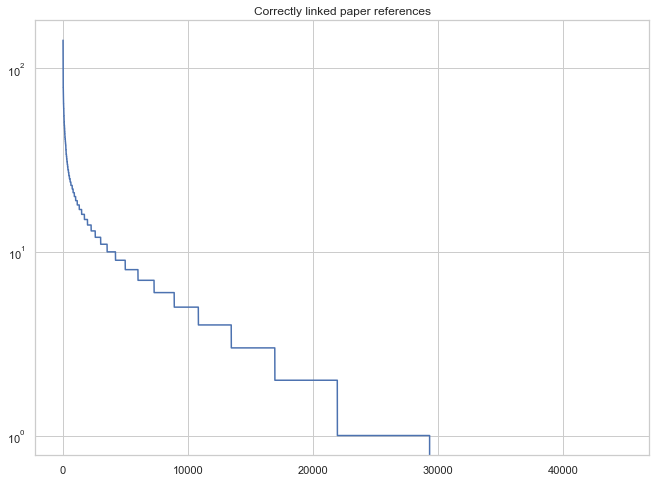

In [ ]:
num_references = sorted([len(paper._references) for paper in papers],
                        reverse=True)
num_referenced_by = sorted([len(paper._referenced_by) for paper in papers],
                           reverse=True)
fig = plt.figure(figsize=(11, 8))
ax = sns.lineplot(y=num_references, x=range(len(papers)))
ax.set(title="Correctly linked paper references", yscale="log");

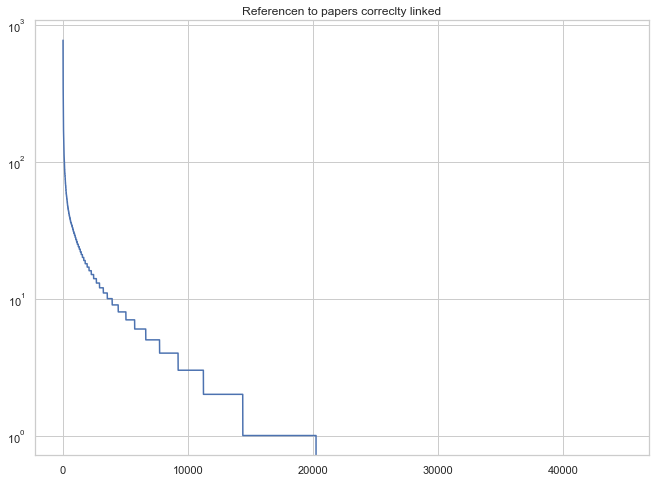

In [ ]:
fig = plt.figure(figsize=(11, 8))
ax = sns.lineplot(y=num_referenced_by, x=range(len(papers)))
ax.set(title="References to papers correclty linked", yscale="log");

From the plot it's concluded that the number of linked references follow a power law, with a tiny bit of them accounting for most of the references.

# PageRank

The following cells will compute the PageRank score based on the previously built paper references link.

In [32]:
# export
def build_papers_reference_graph(papers):
    G = nx.DiGraph()

    # First add the nodes
    for paper in papers:
        G.add_node(paper)
    
    # Then, add the links
    for paper in papers:
        for referenced_paper in paper._references:
            G.add_edge(paper, referenced_paper)
    
    return G

In [33]:
G = build_papers_reference_graph(papers)

In [34]:
G.number_of_nodes(), G.number_of_edges()

(58457, 193183)

In [35]:
pr = nx.pagerank(G)

In [36]:
sorted_pr = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}

Top-ranked papers in the graph

In [37]:
for paper in list(sorted_pr.keys())[:5]:
     paper_as_markdown(paper)


- **Title:** Coronavirus as a possible cause of severe acute respiratory syndrome
- **Authors:** Peiris, JSM; Lai, ST; Poon, LLM; Guan, Y; Yam, LYC; Lim, W; Nicholls, J; Yee, WKS; Yan, WW; Cheung, MT; Cheng, VCC; Chan, KH; Tsang, DNC; Yung, RWH; Ng, TK; Yuen, KY
- **Publish date/time:** 2003-04-19
- **Linked references:** 8
- **Linked referenced by:** 1794
- **Abstract:** Summary Background An outbreak of severe acute respiratory syndrome (SARS) has been reported in Hong Kong. We investigated the viral cause and clinical presentation among 50 patients. Methods We analysed case notes and microbiological findings for 50 patients with SARS, representing more than five separate epidemiologically linked transmission clusters. We defined the clinical presentation and risk factors associated with severe disease and investigated the causal agents by chest radiography and laboratory testing of nasopharyngeal aspirates and sera samples. We compared the laboratory findings with those submitted for microbiological investigation of other diseases from patients whose identity was masked. Findings Patients' age ranged from 23 to 74 years. Fever, chills, myalgia, and cough were the most frequent complaints. When compared with chest radiographic changes, respiratory symptoms and auscultatory findings were disproportionally mild. Patients who were household contacts of other infected people and had older age, lymphopenia, and liver dysfunction were associated with severe disease. A virus belonging to the family Coronaviridae was isolated from two patients. By use of serological and reverse-transcriptase PCR specific for this virus, 45 of 50 patients with SARS, but no controls, had evidence of infection with this virus. Interpretation A coronavirus was isolated from patients with SARS that might be the primary agent associated with this disease. Serological and molecular tests specific for the virus permitted a definitive laboratory diagnosis to be made and allowed further investigation to define whether other cofactors play a part in disease progression.


- **Title:** Severe Acute Respiratory Syndrome (SARS)
- **Authors:** Tsang, K. W.
- **Publish date/time:** 2008-12-31
- **Linked references:** 10
- **Linked referenced by:** 236
- **Abstract:** Severe acute respiratory syndrome (SARS) is caused by a novel coronavirus (SARS-CoV), spread largely via droplets. Patients present with rapidly progressive pneumonia and respiratory failure. Diagnosis requires the demonstration of epidemiological linkage, clinical profiles, and virological evidence of SARS-CoV infection. Treatment of SARS is largely anecdotal. High-dose corticosteroid therapy might be useful for critically ill patients, but previous use of ribavirin (a broad-spectrum antiviral agent) was probably not efficacious. Some survivors of SARS suffer from avascular necrosis of hip and knee joints. Poor prognostic factors include advanced age, comorbidities, and high serum lactate dehydrogenase and neutrophil levels.


- **Title:** World Health Organization
- **Authors:** Ogbu, U.C.; Arah, O.A.
- **Publish date/time:** 2008-08-26
- **Linked references:** 2
- **Linked referenced by:** 1158
- **Abstract:** The World Health Organization is the global authority on health issues. Since its inception in 1948, it has made large strides in advancing its goal of the highest attainable level of health for all people. Through the years, the organization has faced many setbacks, but it has also marked numerous achievements. The global forces that necessitated its establishment continue to mold and influence the organization. This article discusses how the World Health Organization started, its functions, and what it is doing to maintain its relevance in the twenty-first century. This article also brings into focus the fight against tropical diseases.


- **Title:** Further studies on human enteric coronaviruses
- **Authors:** Caul, E. O.; Egglestone, S. I.
- **Publish date/time:** 1977
- **Linked references:** 0
- **Linked referenced by:** 46
- **Abstract:** Comparisons were made between human enteric coronaviruses and the enteric coronaviruses of pigs and calves by negative staining. Examination of human intestinal organ culture fluids at various time intervals after inoculation with the human enteric coronavirus showed increasing numbers of particles in the fluids. Thin sections of the columnar epithelial cells of these explants showed a number of features consistent with the replication of known human and animal coronaviruses. Virus particles found in thin sections had a mean diameter of 68 nm. In addition, a structure was found in thin sections which has not been described previously. This structure may represent the viral nucleocapsid.


- **Title:** Coronavirus Pneumonia Following Autologous Bone Marrow Transplantation for Breast Cancer
- **Authors:** Folz, Rodney J.; Elkordy, Maha A.
- **Publish date/time:** 1999-03-31
- **Linked references:** 6
- **Linked referenced by:** 54
- **Abstract:** Infectious bronchitis virus, otherwise known as coronavirus, can cause mild upper respiratory tract illnesses in children and adults. Rarely has coronavirus been linked, either by serology or nasal wash, to pneumonia. We report a case of a young woman who, following treatment for stage IIIA breast cancer using a high-dose chemotherapy regimen followed by autologous bone marrow and stem cell transplantation, developed respiratory failure and was found to have coronavirus pneumonia as diagnosed by electron microscopy from BAL fluid. We propose that coronavirus should be considered in the differential diagnosis of acute respiratory failure in cancer patients who have undergone high-dose chemotherapy and autologous hematopoietic support.

Here it can be seen that the papers with the highest PageRank are highly cited and in general are works from past decades that probably constitute the basis of current research against COVID-19.

The distribution of PageRank scores will be shown below.

In [ ]:
pr_values = np.array(list(sorted_pr.values()))

# Removing outliers
pr_mean = np.mean(pr_values)
pr_std = np.std(pr_values)
pr_distance = abs(pr_values - pr_mean)
max_std = 1.5
pr_not_outlier = pr_distance < max_std * pr_std
pr_no_outliers = pr_values[pr_not_outlier]

len(pr_values), len(pr_no_outliers), len(pr_values) - len(pr_no_outliers)

(44648, 44176, 472)

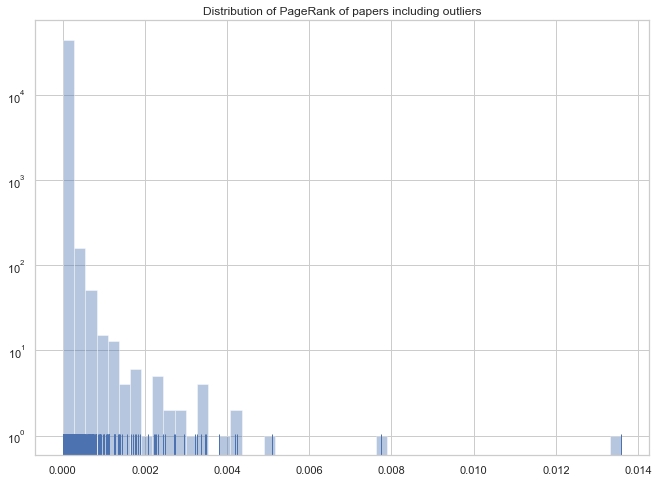

In [ ]:
fig = plt.figure(figsize=(11, 8))
ax = sns.distplot(pr_values, kde=False, rug=True)
ax.set(title="Distribution of PageRank of papers including outliers", yscale="log");

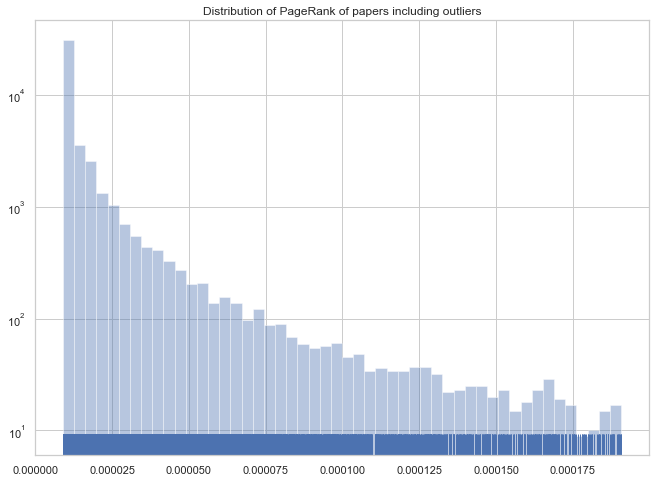

In [ ]:
fig = plt.figure(figsize=(11, 8))
ax = sns.distplot(pr_no_outliers, kde=False, rug=True)
ax.set(title="Distribution of PageRank of papers including outliers", yscale="log")
pass

---

In [38]:
# tell nbdev to generate library from notebooks
from nbdev.export import *
notebook2script()

Converted 00_downloader.ipynb.
Converted 01_references.ipynb.
Converted 02_representations_and_lda.ipynb.
Converted 03_hierarchical_topic_modelling.ipynb.
Converted 04_lda2vec.ipynb.
Converted 05_cook_artifacts.ipynb.
Converted 06_GUI.ipynb.
Converted 98_risotto_precook.ipynb.
Converted 99_risotto_gui.ipynb.
Converted index.ipynb.


In [1]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

---